In [ ]:
import locale
locale.getpreferredencoding()
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
%matplotlib inline

## Helper function to convert js imgs to opencCV imgs

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# Function to convert OpenCV Rectangle bounding box image into a base64 byte string
def bbox_to_bytes(bbox_array):
    """
    Params:
        bbox_array: Numpy array (pixels) containing a rectangle to overlay on the video stream.
    Returns:
        bytes: Base64 image byte string
    """
    # Convert the array into a PIL image
    bbox_PIL = Image.fromarray(bbox_array, 'RGBA')
    iobuf = io.BytesIO()
    # Save the PIL image as a PNG into the in-memory buffer
    bbox_PIL.save(iobuf, format='PNG')
    # Encode the image in base64 and format the output as a data URI
    bbox_bytes = f"data:image/png;base64,{b64encode(iobuf.getvalue()).decode('utf-8')}"

    return bbox_bytes

## Functions to capture webcam in colab

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

## Getting the large dataset

In [ ]:
!pip install -qU ultralytics roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key=API_KEY1)
project = rf.workspace("rock-paper").project("rock-paper-siccors")
version = project.version(1)
small_dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Rock,Paper,Siccors-1 in yolov8:: 100%|██████████| 583/583 [00:00<00:00, 5548.68it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Getting our small dataset

In [ ]:
rf = Roboflow(api_key=API_KEY2)
project = rf.workspace("reyhane2525").project("final-v2-kpqgq")
version = project.version(1)
large_dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to final-v2-1 in yolov8:: 100%|██████████| 15074/15074 [00:02<00:00, 7045.97it/s]


## Merging two datasets

In [ ]:
import os
import shutil

# Define paths
dataset1_path = large_dataset.location
dataset2_path = small_dataset.location
output_path = "/content/merged_dataset/"

# Create output directories
for split in ["train", "valid"]:
    os.makedirs(os.path.join(output_path, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_path, split, "labels"), exist_ok=True)

# Function to copy files
def copy_files(src_images, src_labels, dest_images, dest_labels):
    for file in os.listdir(src_images):
        shutil.copy(os.path.join(src_images, file), dest_images)
    for file in os.listdir(src_labels):
        shutil.copy(os.path.join(src_labels, file), dest_labels)

# Merge dataset1 and dataset2
for split in ["train", "valid"]:
    copy_files(
        os.path.join(dataset1_path, split, "images"),
        os.path.join(dataset1_path, split, "labels"),
        os.path.join(output_path, split, "images"),
        os.path.join(output_path, split, "labels")
    )
    copy_files(
        os.path.join(dataset2_path, split, "images"),
        os.path.join(dataset2_path, split, "labels"),
        os.path.join(output_path, split, "images"),
        os.path.join(output_path, split, "labels")
    )

In [ ]:
data_yaml = """
train: ../train/images
val: ../valid/images
test: ../test/images

nc: 3
names: ['Paper', 'Rock', 'Scissors']
"""

with open("/content/merged_dataset/data.yaml", "w") as file:
    file.write(data_yaml)

## Fine tuning YOLO model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from ultralytics import YOLO
import os

# Load a pretrained YOLOv11 model
model = YOLO('yolov8n.pt')

# Fine-tune the model using your dataset
results = model.train(
    data=os.path.join("/content/merged_dataset/", "data.yaml"),
    epochs=25,     #changes the epochs
    imgsz=640,
    name='yolov8n_rps',
    fraction=0.8,
    val=True,
    plots=True,
    patience=5   # Early stopping patience (epochs to wait without improvement)
)

100%|██████████| 6.25M/6.25M [00:00<00:00, 371MB/s]

Ultralytics 8.3.70 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/merged_dataset/data.yaml, epochs=25, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_rps, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=0.8, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

Model summary: 225 layers, 3,011,433 parameters, 3,011,417 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir runs/detect/yolov8n_rps', view at http://localhost:6006/
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅


train: Scanning /content/merged_dataset/train/labels.cache... 5855 images, 27 backgrounds, 0 corrupt: 100%|██████████| 5855/5855 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/merged_dataset/valid/labels.cache... 378 images, 2 backgrounds, 0 corrupt: 100%|██████████| 378/378 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8n_rps/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8n_rps
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      2.78G      1.542      2.645      1.762         22        640: 100%|██████████| 366/366 [02:10<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.58it/s]

                   all        378        472      0.422       0.52      0.466      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      2.31G      1.532      1.999      1.744         33        640: 100%|██████████| 366/366 [02:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.24it/s]

                   all        378        472      0.704      0.505      0.651      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      2.32G      1.528      1.798      1.733         35        640: 100%|██████████| 366/366 [02:06<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.57it/s]

                   all        378        472      0.573      0.614      0.639      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      2.32G      1.491      1.682      1.717         29        640: 100%|██████████| 366/366 [02:04<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.15it/s]

                   all        378        472      0.764      0.674      0.772      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      2.32G      1.449      1.559      1.668         30        640: 100%|██████████| 366/366 [02:03<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.60it/s]

                   all        378        472      0.768      0.776      0.833      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      2.32G      1.408      1.475      1.643         28        640: 100%|██████████| 366/366 [02:04<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.00it/s]

                   all        378        472      0.801      0.823      0.886      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25       2.3G      1.361      1.396      1.608         43        640: 100%|██████████| 366/366 [02:01<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

                   all        378        472      0.805      0.798       0.86      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      2.32G      1.335      1.324      1.586         41        640: 100%|██████████| 366/366 [02:03<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]

                   all        378        472      0.856      0.887      0.934      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25       2.3G      1.308      1.271      1.559         31        640: 100%|██████████| 366/366 [02:01<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.52it/s]

                   all        378        472      0.785      0.774      0.872      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      2.31G      1.278      1.206      1.533         25        640: 100%|██████████| 366/366 [02:04<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.70it/s]

                   all        378        472      0.861       0.84      0.923      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      2.32G       1.26      1.173      1.517         31        640: 100%|██████████| 366/366 [02:02<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

                   all        378        472      0.868      0.863       0.93      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25       2.3G      1.245       1.14        1.5         35        640: 100%|██████████| 366/366 [02:04<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.52it/s]

                   all        378        472       0.84      0.889      0.942      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      2.32G      1.218      1.102      1.484         41        640: 100%|██████████| 366/366 [02:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.33it/s]

                   all        378        472      0.847      0.859      0.912        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25       2.3G      1.205      1.087       1.48         39        640: 100%|██████████| 366/366 [02:03<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.51it/s]

                   all        378        472      0.901      0.862      0.937      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25       2.3G      1.183      1.031      1.462         42        640: 100%|██████████| 366/366 [02:00<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.80it/s]

                   all        378        472      0.897      0.894      0.939      0.624


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      2.38G      1.109     0.6849      1.475         19        640: 100%|██████████| 366/366 [02:00<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.45it/s]

                   all        378        472      0.915       0.85      0.932      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      2.31G      1.066     0.6324      1.432         20        640: 100%|██████████| 366/366 [01:55<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.29it/s]

                   all        378        472      0.906      0.895      0.945      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25       2.3G      1.038     0.5946      1.419         20        640: 100%|██████████| 366/366 [01:55<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.29it/s]

                   all        378        472       0.91      0.891      0.949      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      2.31G      1.013     0.5688        1.4         21        640: 100%|██████████| 366/366 [01:56<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]

                   all        378        472      0.916      0.914      0.949      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25       2.3G     0.9893     0.5388      1.373         19        640: 100%|██████████| 366/366 [01:57<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.71it/s]

                   all        378        472      0.941      0.936      0.966      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      2.31G     0.9668     0.5243      1.363         16        640: 100%|██████████| 366/366 [01:58<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.88it/s]

                   all        378        472      0.938      0.931      0.954      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25       2.3G     0.9451     0.4988      1.334         18        640: 100%|██████████| 366/366 [01:58<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.90it/s]

                   all        378        472      0.936      0.929      0.951      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      2.31G      0.913     0.4828      1.307         17        640: 100%|██████████| 366/366 [01:55<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

                   all        378        472       0.94      0.919      0.958      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25       2.3G      0.902     0.4652      1.295         16        640: 100%|██████████| 366/366 [01:55<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.81it/s]

                   all        378        472      0.943       0.94      0.961      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      2.31G     0.8693     0.4515      1.274         20        640: 100%|██████████| 366/366 [01:56<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]

                   all        378        472      0.953      0.935      0.959      0.682
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 20, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



25 epochs completed in 0.879 hours.
Optimizer stripped from runs/detect/yolov8n_rps/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_rps/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_rps/weights/best.pt...
Ultralytics 8.3.70 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


                   all        378        472      0.941      0.937      0.966      0.688
                 Paper        171        172      0.884      0.885      0.923      0.656
                  Rock        124        127      0.946       0.96      0.985      0.671
              Scissors        140        173      0.994      0.965      0.991      0.738
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/yolov8n_rps


In [ ]:
import os
import glob

# Define the directory path
dataset_path = "/content/merged_dataset/train/images"

# Define the image file extensions you want to count
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.gif']

# Initialize a counter for the number of images
num_images = 0

# Loop through each image extension and count the files
for ext in image_extensions:
    num_images += len(glob.glob(os.path.join(dataset_path, ext)))

print(f"Number of images in {dataset_path}: {num_images}")

Number of images in /content/merged_dataset/train/images: 7319


In [ ]:
import os
import shutil

model_path = "/content/runs/detect/yolov8n_rps/weights/best.pt"

drive_save_path = "/content/drive/My Drive/Weights/best.pt"

os.makedirs(os.path.dirname(drive_save_path), exist_ok=True)

shutil.copy(model_path, drive_save_path)

print(f"Model saved to Google Drive: {drive_save_path}")

Model saved to Google Drive: /content/drive/My Drive/Weights/best.pt


## Plotting the performance of model

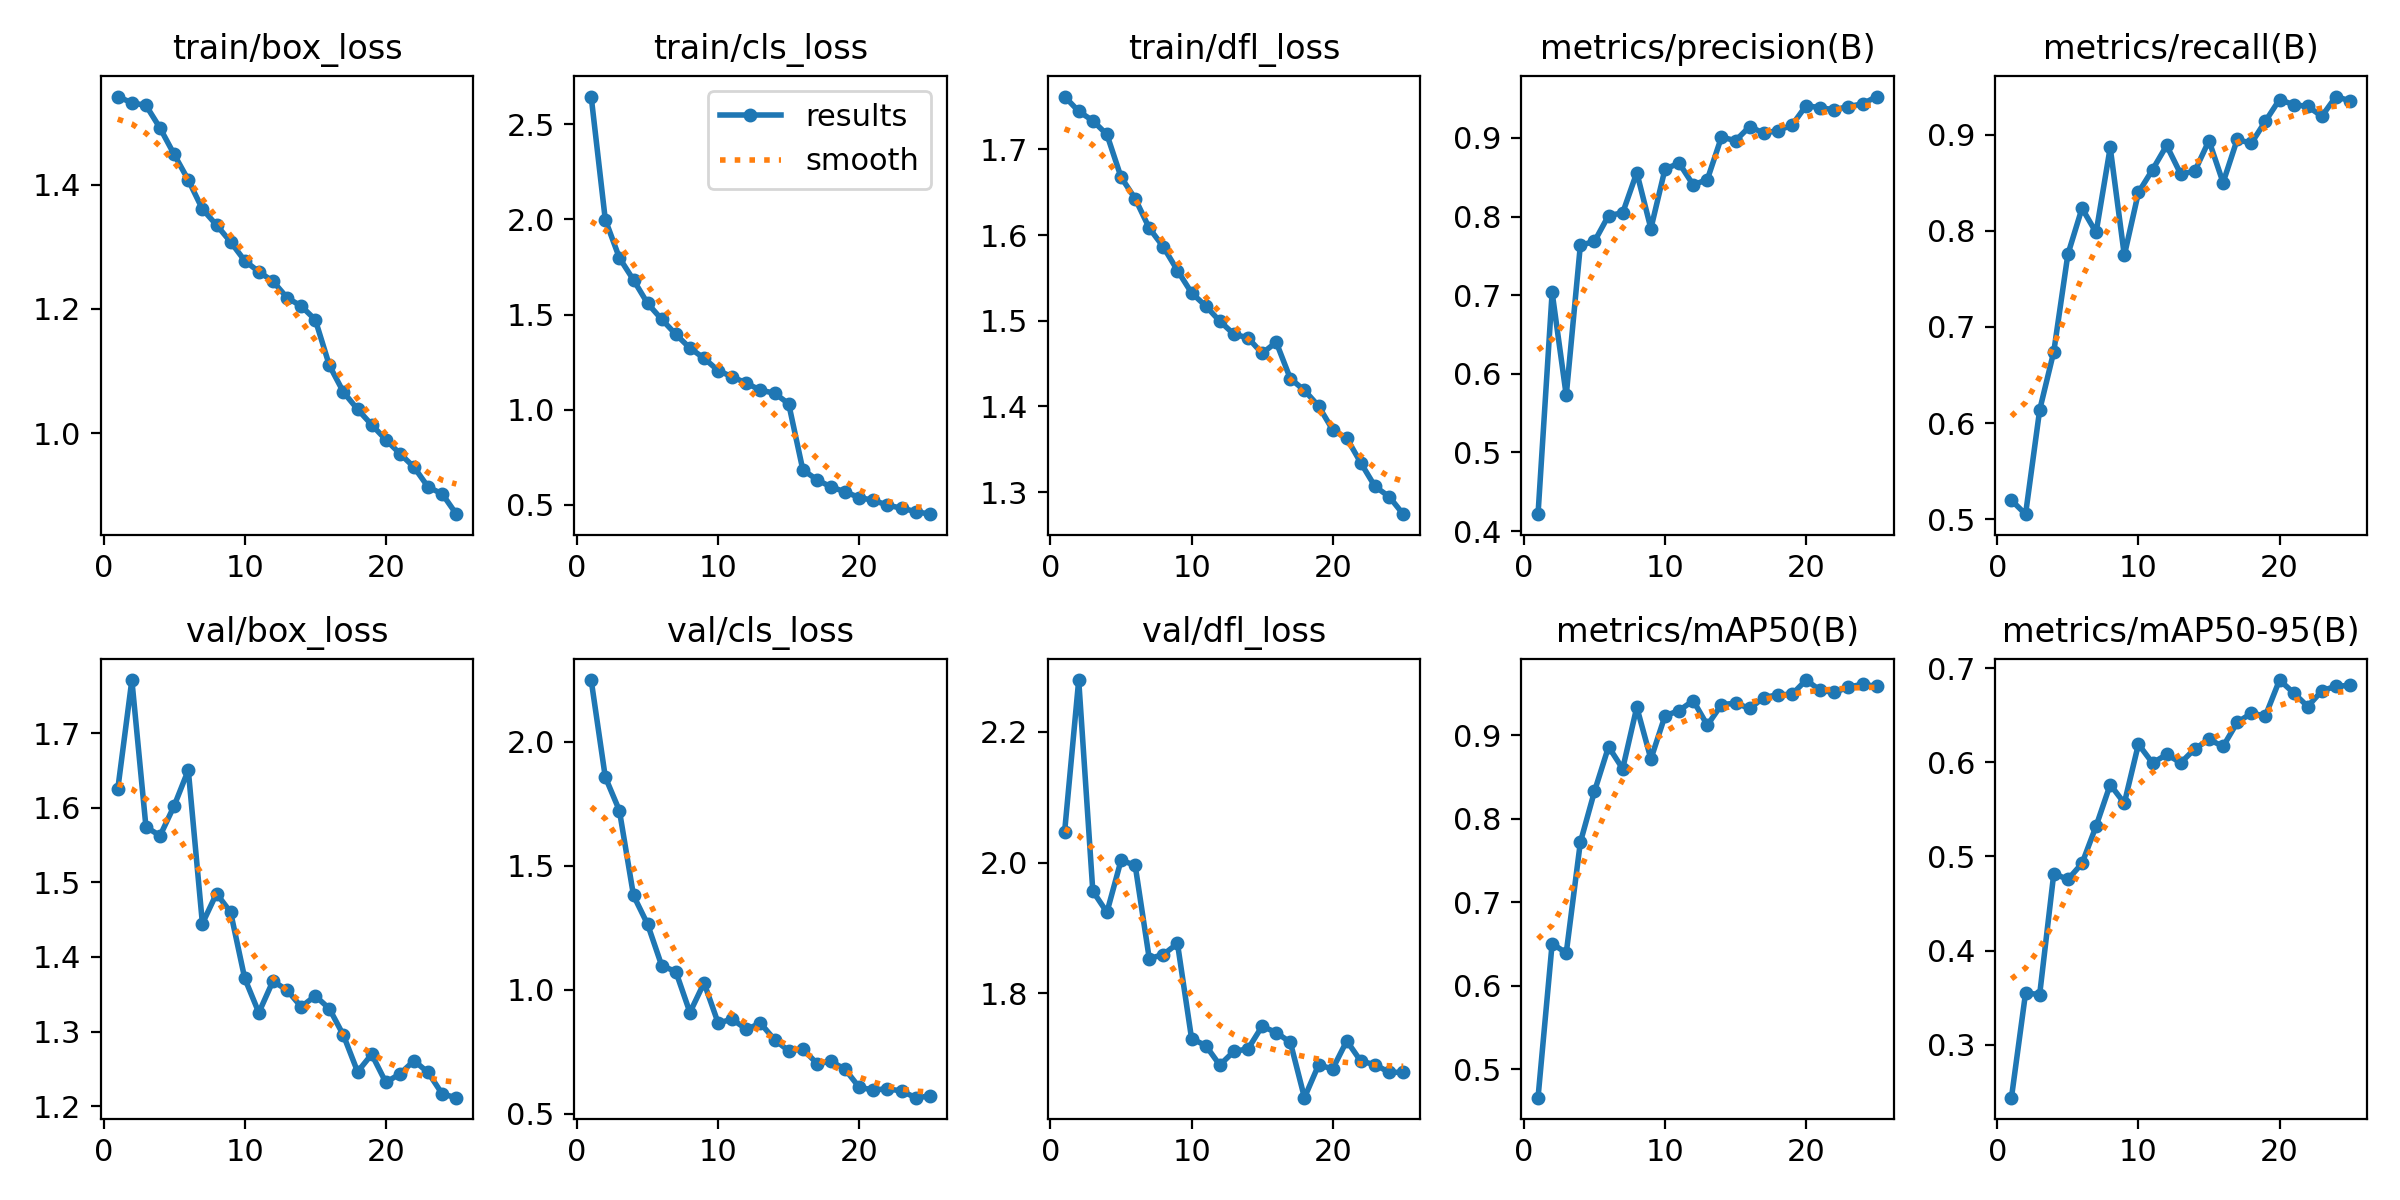

In [ ]:
from IPython.display import Image
Image(filename='runs/detect/yolov8n_rps/results.png', width=1200)

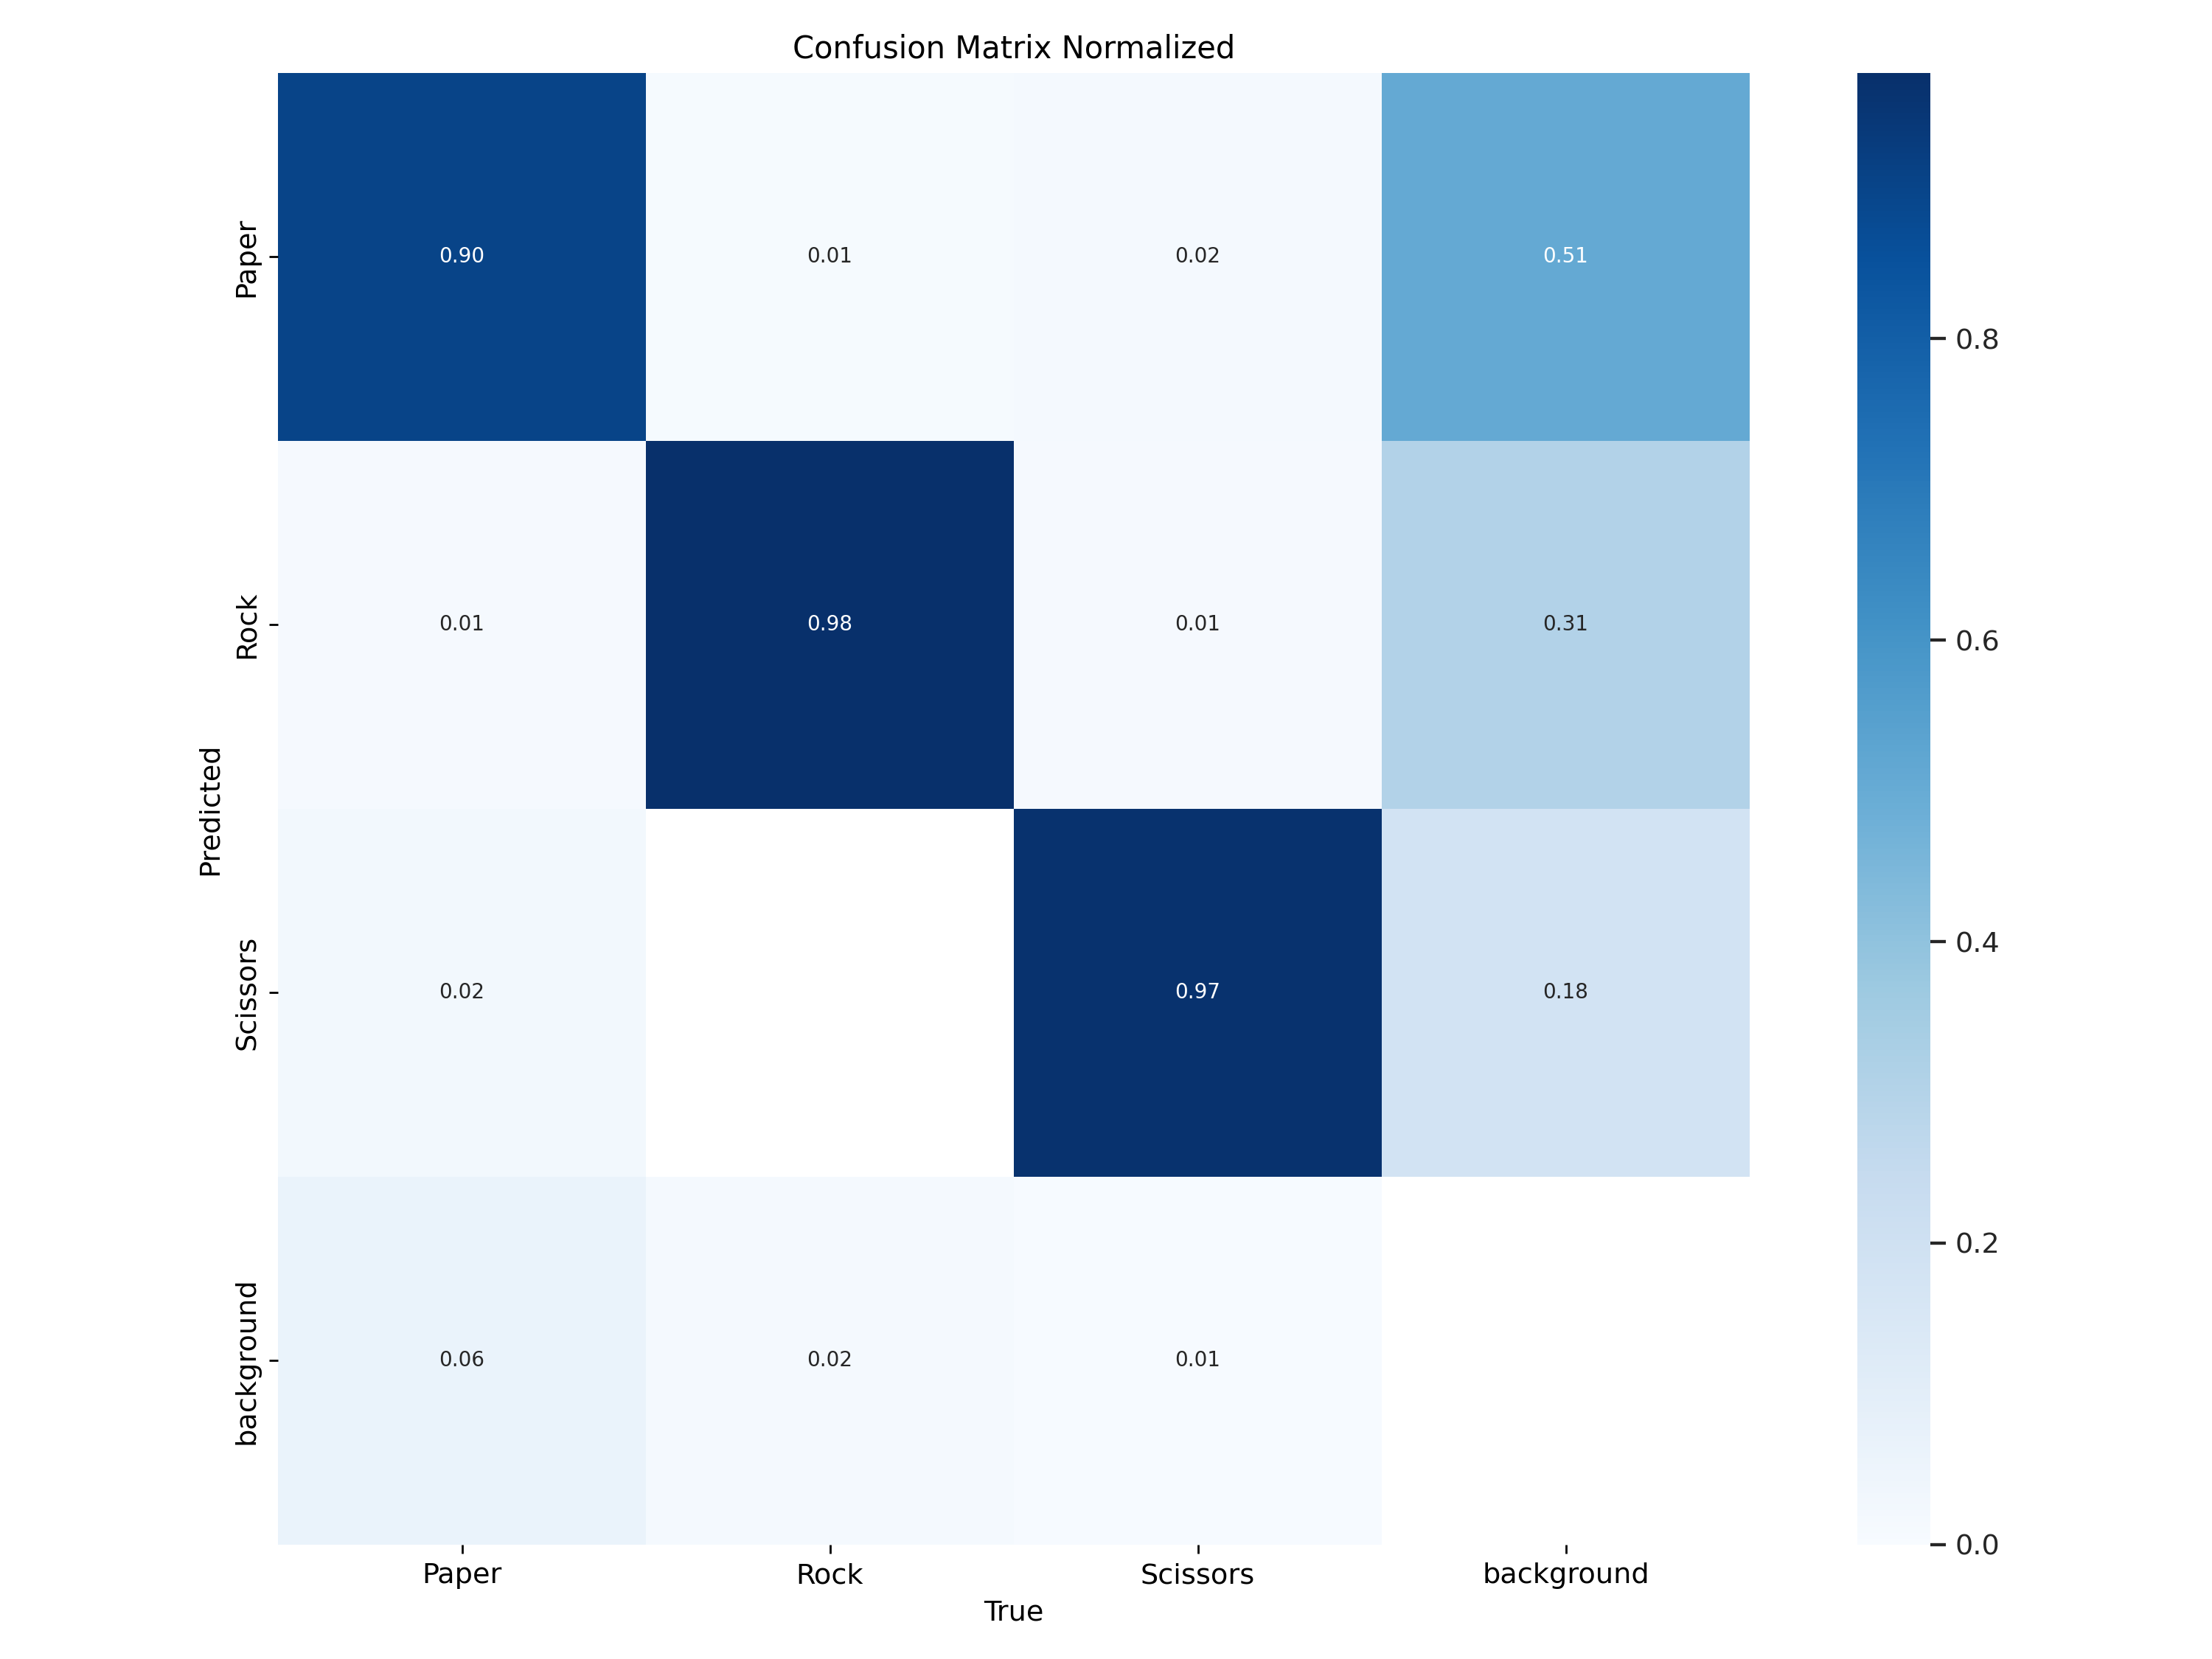

In [ ]:
Image(filename='runs/detect/yolov8n_rps/confusion_matrix_normalized.png', width=1000)

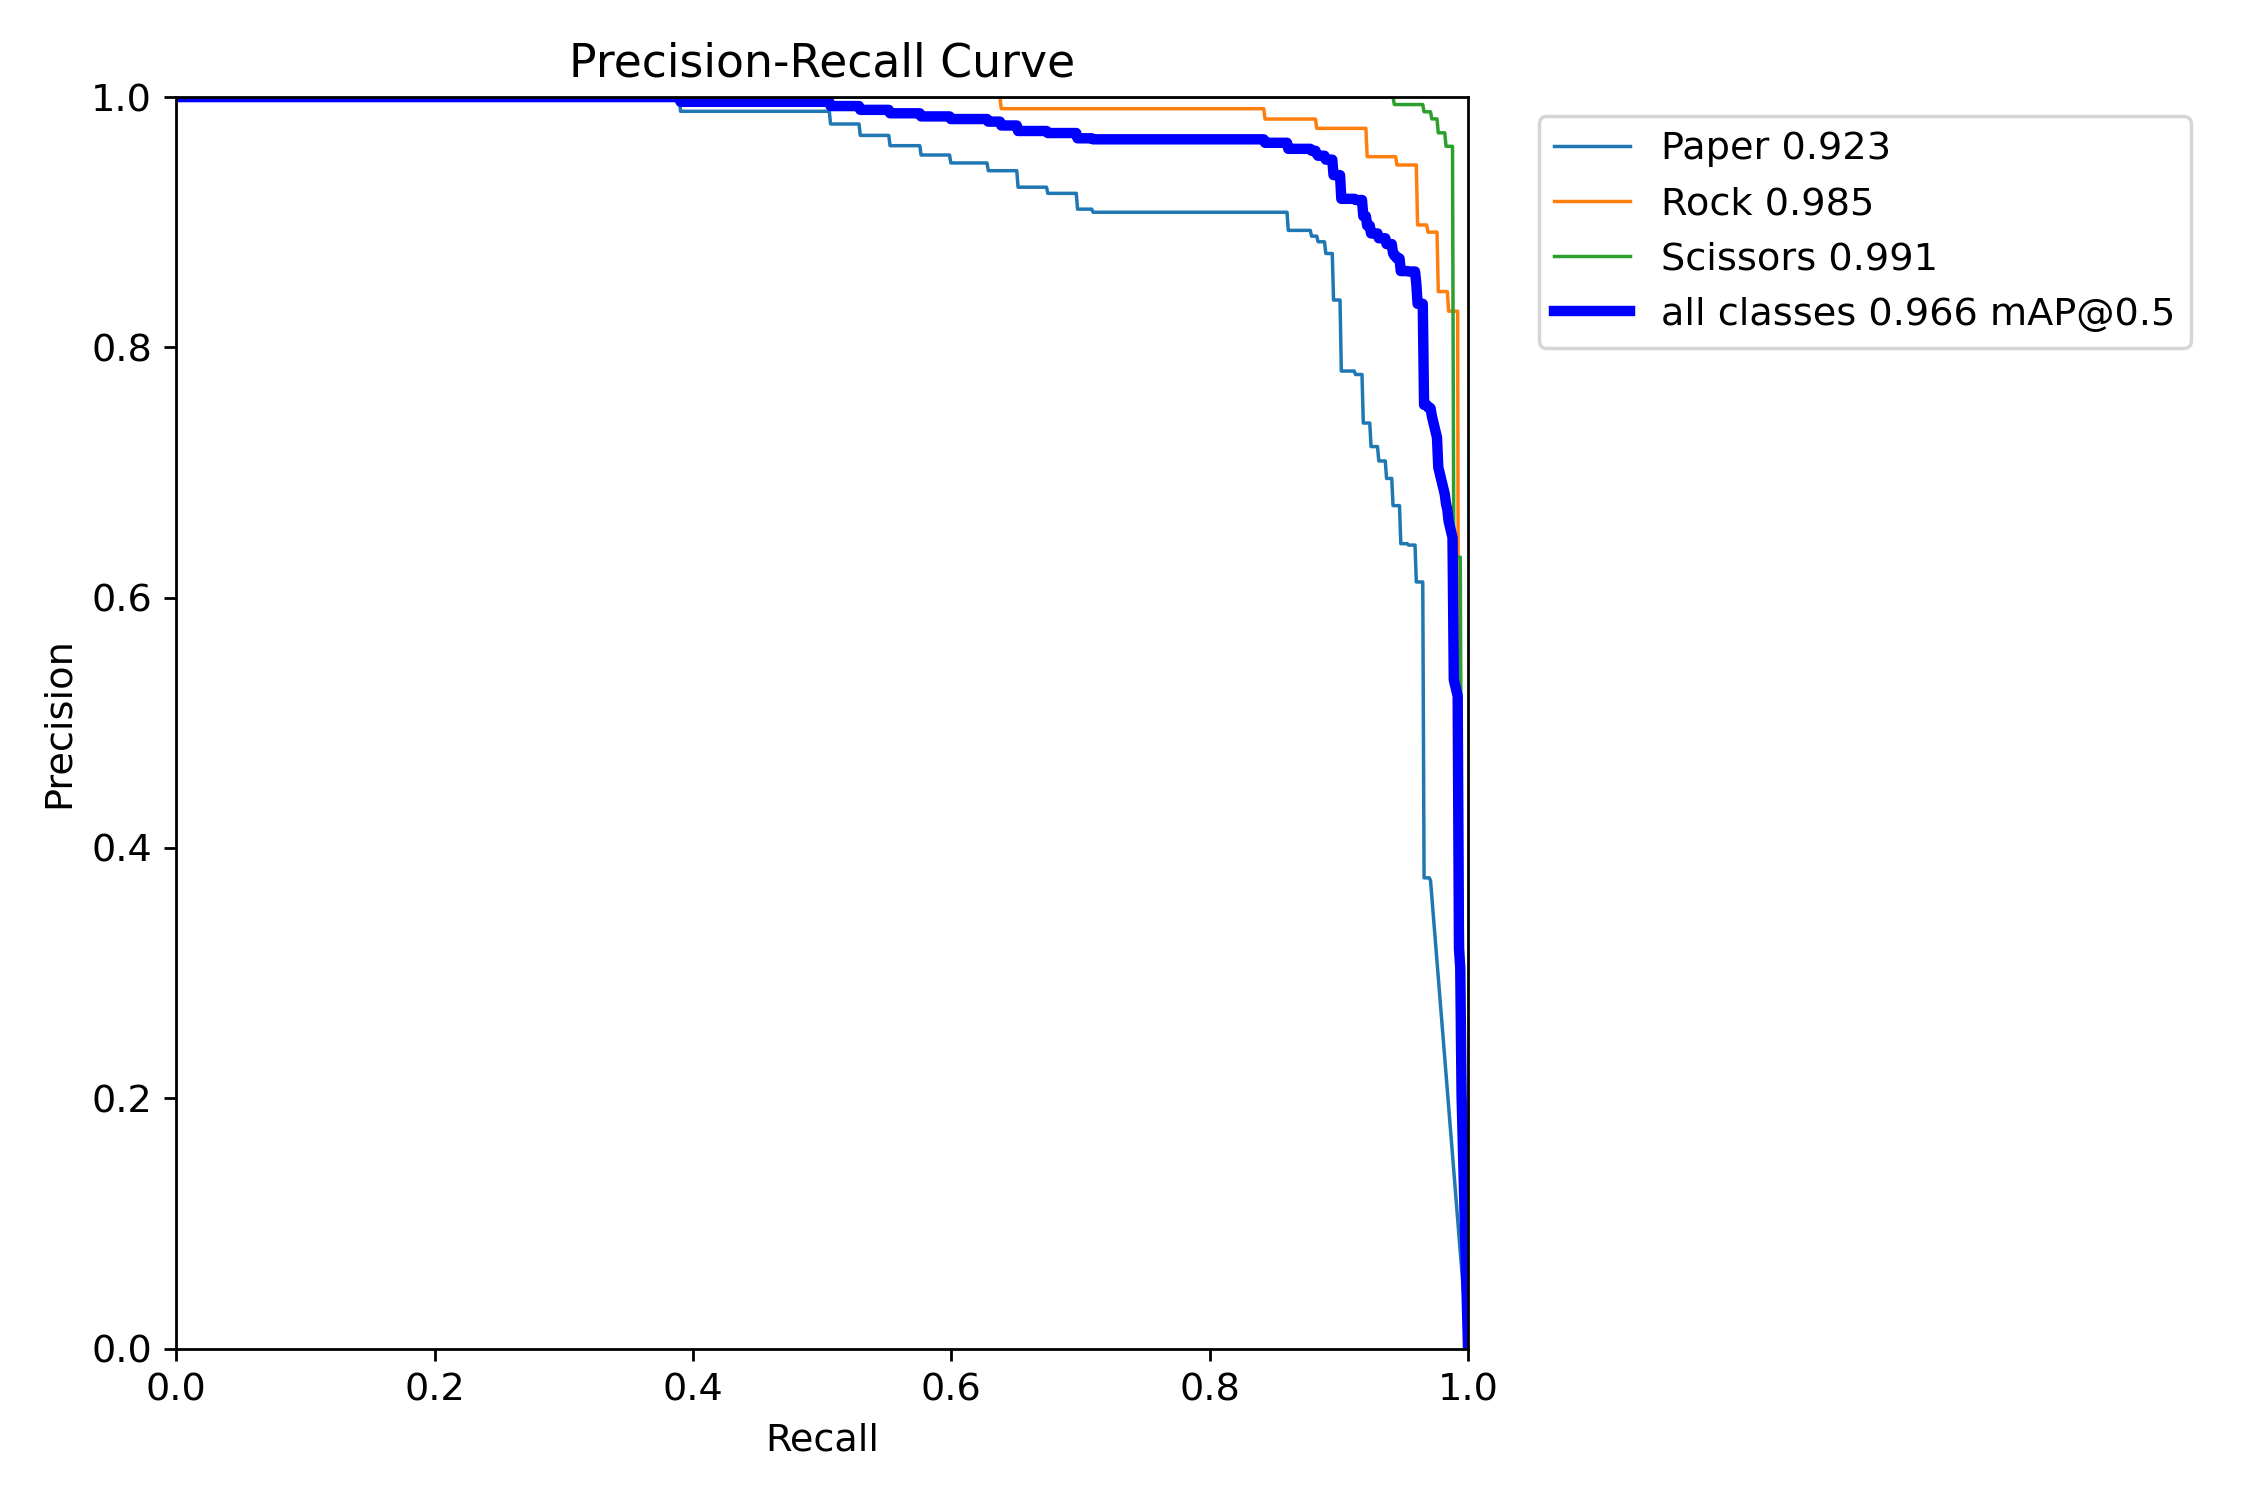

In [ ]:
Image(filename='runs/detect/yolov8n_rps/PR_curve.png', width=600)

In [ ]:
from ultralytics import YOLO
model_path = '/content/drive/My Drive/Weights/best.pt'  # Example: loading the best model

# Load the model
model = YOLO(model_path)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## JS functions used in the game

In [ ]:
from IPython.display import Javascript, display, HTML
import time

def display_countdown_number(number, element_id='number-display', top_position='110px', color='red'):
    # JavaScript code to update or create the number element
    js = Javascript(f'''
        // Check if the number element already exists
        var numberElement = document.getElementById('{element_id}');

        // If it doesn't exist, create it
        if (!numberElement) {{
            numberElement = document.createElement('div');
            numberElement.id = '{element_id}'; // Assign an ID to the element
            numberElement.style.position = "absolute";
            numberElement.style.top = "{top_position}";
            numberElement.style.left = "60%";
            numberElement.style.transform = "translateX(-50%)";
            numberElement.style.fontSize = "30px";
            numberElement.style.fontWeight = "bold";
            numberElement.style.color = "{color}";
            document.body.appendChild(numberElement);
        }}

        // Update the number text
        numberElement.innerText = "Countdown: {number}";
    ''')
    display(js)

def display_scores(player_left_score, player_right_score):
    # JavaScript code to update or create the score element
    js = Javascript(f'''
        // Check if the score element already exists
        var scoreElement = document.getElementById('score-display');

        // If it doesn't exist, create it
        if (!scoreElement) {{
            scoreElement = document.createElement('div');
            scoreElement.id = 'score-display'; // Assign an ID to the element
            scoreElement.style.position = "absolute";
            scoreElement.style.top = "70px";
            scoreElement.style.left = "60%";
            scoreElement.style.transform = "translateX(-50%)";
            scoreElement.style.fontSize = "20px";
            scoreElement.style.fontWeight = "bold";
            scoreElement.style.color = "blue";
            document.body.appendChild(scoreElement);
        }}

        // Update the score text
        scoreElement.innerText = "Player 1: {player_left_score} - Player 2: {player_right_score}";
    ''')
    display(js)

def display_string(text, element_id='string-display', top_position='20px', color='blue', font_size='20px'):

    # JavaScript code to update or create the string element
    js = Javascript(f'''
        // Check if the string element already exists
        var stringElement = document.getElementById('{element_id}');

        // If it doesn't exist, create it
        if (!stringElement) {{
            stringElement = document.createElement('div');
            stringElement.id = '{element_id}'; // Assign an ID to the element
            stringElement.style.position = "absolute";
            stringElement.style.top = "{top_position}";
            stringElement.style.left = "60%";
            stringElement.style.transform = "translateX(-50%)";
            stringElement.style.fontSize = "{font_size}";
            stringElement.style.fontWeight = "bold";
            stringElement.style.color = "{color}";
            document.body.appendChild(stringElement);
        }}

        // Update the string text
        stringElement.innerText = "{text}";
    ''')
    display(js)

## Test the YOLO model on webcam

In [ ]:
## Rozhan's code
from PIL import Image
video_stream()

label_html = 'Capturing...'
bbox = ''
count = 0

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    frame = js_to_image(js_reply["img"])

    results = model.predict(source=frame, imgsz=640, verbose=False, conf=0.4)
    initial_gestures = []
    for result in results:
        for box in result.boxes:
            class_id = int(box.cls)
            confidence = float(box.conf)  # Confidence score
            label = model.names[class_id]  # Class label (rock, paper, scissors)
            initial_gestures.append((label, confidence, box.xyxy[0].tolist()))  # Add bounding box coordinates

    bbox_array = np.zeros([480, 640, 4], dtype=np.uint8)


    for gesture in initial_gestures:
        label, confidence, bbox_coords = gesture
        x1, y1, x2, y2 = map(int, bbox_coords)

        bbox_array = cv2.rectangle(bbox_array, (x1, y1), (x2, y2), (255, 0, 255), 2)

        bbox_array = cv2.putText(bbox_array, f"{label} ({confidence:.2f})", (x1, y1 - 10),
                                 cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 255), 2)

    # Set alpha channel for the overlay
    bbox_array[:, :, 3] = (bbox_array.max(axis=2) > 0).astype(int) * 255

    # Convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)

    # Update bbox so the next frame gets the new overlay
    bbox = bbox_bytes


## Game rule functions

In [ ]:
import time

# Initialize player scores and the required number of victories
player_left_score = 0
player_right_score = 0
victories_required = 2

# Create variables to track if players have cheated
player_left_cheated = False
player_right_cheated = False

# Function to determine the winner of a round (Rock, Paper, Scissors)
def determine_winner(player_1_choice, player_2_choice):

    if player_1_choice == player_2_choice:
        return "draw"
    elif (player_1_choice == "Rock" and player_2_choice == "Scissors") or \
         (player_1_choice == "Paper" and player_2_choice == "Rock") or \
         (player_1_choice == "Scissors" and player_2_choice == "Paper"):
        return "player_left"
    else:
        return "player_right"

# Function to handle the game logic during a round
def handle_round(player_left_gesture, player_right_gesture):

    global player_left_score, player_right_score, player_left_cheated, player_right_cheated

    if player_left_gesture is None:
        player_left_cheated = True
        display_string("Player left cheated!")
        player_left_score = player_left_score - 1 if player_left_score > 0 else 0
        return
    if player_right_gesture is None:
        player_right_cheated = True
        display_string("Player right cheated!")
        player_right_score = player_right_score - 1 if player_right_score > 0 else 0
        return


    # Check if players have selected a valid gesture (rock, paper, or scissors)
    valid_choices = ["Rock", "Paper", "Scissors"]
    player_1_choice = None
    player_2_choice = None

    player_1_choice = player_left_gesture[0] if player_left_gesture[0] in valid_choices else None
    player_2_choice = player_right_gesture[0] if player_right_gesture[0] in valid_choices else None

    round_winner = determine_winner(player_1_choice, player_2_choice)

    if round_winner == "player_left":
        player_left_score += 1
    elif round_winner == "player_right":
        player_right_score += 1


def get_bounding_boxes(frame):
    results = model.predict(source=final_frame, imgsz=640, conf=0.2, verbose=False)
    gestures = []
    for result in results:
        for box in result.boxes:
            class_id = int(box.cls)
            confidence = float(box.conf)  # Confidence score
            label = model.names[class_id]  # Class label (rock, paper, scissors)
            result_bbox = box.xyxy[0].tolist()
            center_x = (result_bbox[0] + result_bbox[2]) / 2

            # Determine if the gesture is on the left or right side of the screen
            side = 'left' if center_x < 640 / 2 else 'right'

            gestures.append((label, confidence, box.xyxy[0].tolist(), side))
    return gestures

def check_motion(prev_gestures, curr_gestures, motion_threshold=10):

    motion_status = {'left': True, 'right': True}  # Assume motion by default

    # Create dictionaries to map sides to their respective gestures
    prev_gestures_dict = {gesture[3]: gesture for gesture in prev_gestures}  # {side: gesture}
    curr_gestures_dict = {gesture[3]: gesture for gesture in curr_gestures}  # {side: gesture}

    # Check motion for each side
    for side in ['left', 'right']:
        if side in prev_gestures_dict and side in curr_gestures_dict:
            prev_bbox = prev_gestures_dict[side][2]  # Bounding box of the previous gesture
            curr_bbox = curr_gestures_dict[side][2]  # Bounding box of the current gesture

            # Calculate the center points of the bounding boxes
            prev_center = [(prev_bbox[0] + prev_bbox[2]) / 2, (prev_bbox[1] + prev_bbox[3]) / 2]
            curr_center = [(curr_bbox[0] + curr_bbox[2]) / 2, (curr_bbox[1] + curr_bbox[3]) / 2]

            # Calculate the Euclidean distance between the centers
            motion_distance = np.linalg.norm(np.array(curr_center) - np.array(prev_center))

            # Check if the motion distance is below the threshold
            motion_status[side] = motion_distance >= motion_threshold

    return motion_status

def display_game_status():
    if player_left_score >= victories_required:
        display_string("Player left wins the game!")
        return True
    elif player_right_score >= victories_required:
        display_string("Player right wins the game!")
        return True
    return False


def check_initial_gestures(gestures):

    if len(gestures) < 2:
        return False
    for gesture in gestures:
        label = gesture[0]
        if label != "Rock":
            return False
    return True



## RPS game on webcam using YOLO

---



In [ ]:
## Rozhan's code
from PIL import Image
video_stream()

label_html = 'Capturing...'
countdown_duration = 3
player_left_score = 0
player_right_score = 0

while True:
    player_left_cheated = False
    player_right_cheated = False
    display_scores(player_left_score, player_right_score)
    display_string("New Round! Show your rocks please!")

    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    bbox_array[:, :, 3] = (bbox_array.max(axis=2) > 0).astype(int) * 255
    bbox_bytes = bbox_to_bytes(bbox_array)
    bbox = bbox_bytes

    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    initial_frame = js_to_image(js_reply["img"])

    # Detect initial gestures (players should show "Rock")
    results = model.predict(source=initial_frame, imgsz=640, conf=0.3, verbose=False)
    initial_gestures = []
    for result in results:
        for box in result.boxes:
            class_id = int(box.cls)
            confidence = float(box.conf)
            label = model.names[class_id]  # Class label (rock, paper, scissors)
            initial_gestures.append((label, confidence, box.xyxy[0].tolist()))


    if not check_initial_gestures(initial_gestures):
        continue

    display_string("Move your rocks!")
    start_time = time.time()
    end_time = start_time + countdown_duration
    prev_gestures = {}

    while end_time >= time.time():
        display_countdown_number(int(end_time - time.time()))
        inner_js_reply = video_frame(label_html, "")
        final_frame = js_to_image(inner_js_reply["img"])

        curr_gestures = get_bounding_boxes(final_frame)

        motion_status = check_motion(prev_gestures, curr_gestures, motion_threshold=10)

        for side, status in motion_status.items():
            if not status:  # No motion detected
                display_string(f"Player {side} No Motion Detected")
                if side == 'left' and player_left_score > 0:
                    player_left_score -= 1
                elif side == 'right' and player_right_score > 0:
                    player_right_score -= 1
                time.sleep(0.2)
                display_string("Move your rocks!")

        prev_gestures = curr_gestures

        time.sleep(0.1)


    display_string("Show your gestures!")
    time.sleep(1)

    js_reply = video_frame(label_html, "")
    if not js_reply:
        break
    final_frame = js_to_image(js_reply["img"])



    # Detect current gestures
    current_gestures = get_bounding_boxes(final_frame)

    player_left_gesture = None
    player_right_gesture = None

    for gesture in current_gestures:
        if gesture[3] == 'left':
            player_left_gesture = gesture
        elif gesture[3] == 'right':
            player_right_gesture = gesture

    handle_round(player_left_gesture, player_right_gesture)
    display_scores(player_left_score, player_right_score)

    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    for gesture in current_gestures[:2]:
        label, confidence, bbox_coords, _ = gesture
        x1, y1, x2, y2 = map(int, bbox_coords)

        bbox_array = cv2.rectangle(bbox_array, (x1, y1), (x2, y2), (255, 0, 255), 2)

        bbox_array = cv2.putText(bbox_array, f"{label} ({confidence:.2f})", (x1, y1 - 10),
                                 cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 255), 2)


    # Set alpha channel for the overlay
    bbox_array[:, :, 3] = (bbox_array.max(axis=2) > 0).astype(int) * 255

    # Convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)

    # Update bbox so the next frame gets the new overlay
    bbox = bbox_bytes

    game_over = display_game_status()

    js_reply = video_frame(label_html, bbox)

    time.sleep(3)

    if game_over:
        bbox_array = np.zeros([480,640,4], dtype=np.uint8)
        bbox_array[:, :, 3] = (bbox_array.max(axis=2) > 0).astype(int) * 255
        bbox_bytes = bbox_to_bytes(bbox_array)
        bbox = bbox_bytes

        js_reply = video_frame(label_html, bbox)
        break